In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.3.5 전이 학습을 통한 개, 고양이 분류 문제

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import get_file
import os

train_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

def get_data(fname, origin, extract):
    data_dir = get_file(fname=fname, origin=origin, extract=extract)
    data_dir = os.path.join(os.path.dirname(data_dir), 'cats_and_dogs_filtered')
    return data_dir

path_dir = get_data('train.zip', train_url, 'True')

train_dir = os.path.join(path_dir, 'train')
validation_dir = os.path.join(path_dir, 'validation')

print('\n', train_dir)
print(validation_dir)

68606236/68606236 [==============================] - 1s 0us/step

 /root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [2]:
!du -h /root/.keras/datasets/cats_and_dogs_filtered

23M	/root/.keras/datasets/cats_and_dogs_filtered/train/cats
26M	/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
48M	/root/.keras/datasets/cats_and_dogs_filtered/train
11M	/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
13M	/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
24M	/root/.keras/datasets/cats_and_dogs_filtered/validation
72M	/root/.keras/datasets/cats_and_dogs_filtered


In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
  directory=train_dir,
  batch_size=32,# Default: 32
  image_size=(256, 256),# Defaults: (256, 256)
  shuffle=True,# Default: True
  seed=2022)

validation_ds = image_dataset_from_directory(
  directory=validation_dir,
  batch_size=32,# Default: 32
  image_size=(256, 256),# Defaults: (256, 256)
  shuffle=True,# Default: True
  seed=2022)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [4]:
for data, labels in train_ds.take(1):
    print(data.shape)
    print(labels.shape)

(32, 256, 256, 3)
(32,)


In [5]:
class_names = train_ds.class_names

print(class_names)

['cats', 'dogs']


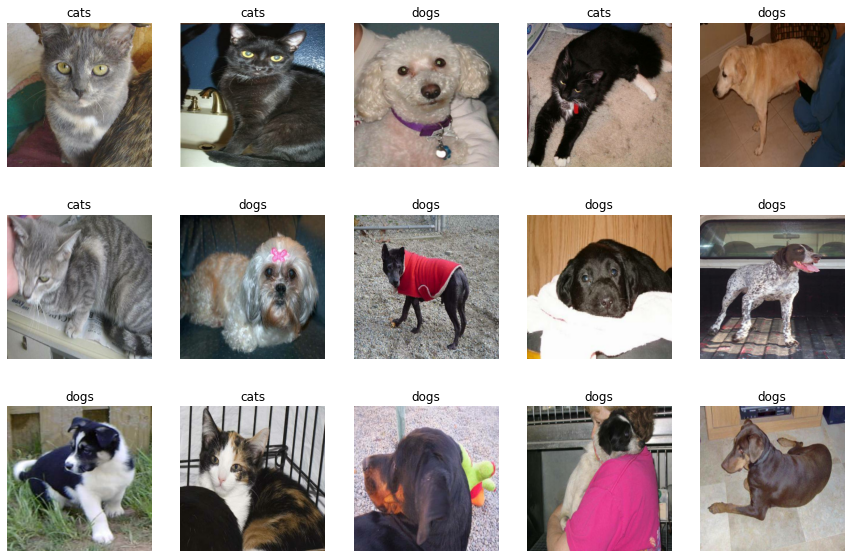

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
from tensorflow.keras.applications import ResNet50

resnet_model = ResNet50(input_shape=[256, 256, 3],
                        weights='imagenet',
                        include_top=False,
                        classes=2)

94765736/94765736 [==============================] - 1s 0us/step


In [8]:
resnet_model.trainable = True

resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [9]:
resnet_model.trainable = False

resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

model = Sequential([
    Rescaling(scale=1./255, input_shape=(256, 256, 3)),
    resnet_model,

    Flatten(),
    Dense(units=32, activation='relu'),
    Dropout(0.2),    
    Dense(units=1) # class_names: ['cats', 'dogs']
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 32)                4194336   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 27,782,081
Trainable params: 4,194,369
Non

In [11]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
%%time

history = model.fit(train_ds, 
                    validation_data=validation_ds, 
                    epochs=5)

Epoch 1/5
63/63 [==============================] - 14s 213ms/step - loss: 0.7479 - accuracy: 0.5180 - val_loss: 0.7143 - val_accuracy: 0.5100
Epoch 2/5
63/63 [==============================] - 14s 216ms/step - loss: 0.6914 - accuracy: 0.5100 - val_loss: 0.7073 - val_accuracy: 0.5100
Epoch 3/5
63/63 [==============================] - 14s 211ms/step - loss: 0.7320 - accuracy: 0.5165 - val_loss: 0.7067 - val_accuracy: 0.5110
Epoch 4/5
63/63 [==============================] - 14s 215ms/step - loss: 0.6947 - accuracy: 0.5115 - val_loss: 0.7064 - val_accuracy: 0.5090
Epoch 5/5
63/63 [==============================] - 14s 214ms/step - loss: 0.7231 - accuracy: 0.5125 - val_loss: 0.7080 - val_accuracy: 0.5110
CPU times: user 51.5 s, sys: 5.54 s, total: 57 s
Wall time: 1min 15s


In [17]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(specs=[[{"secondary_y": True}]])

# model history
epoch = history.epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Scatter
fig.add_trace(go.Scatter(x=epoch, y=loss, name="loss"),secondary_y=False,)
fig.add_trace(go.Scatter(x=epoch, y=val_loss, name="val_loss"),secondary_y=False,)
fig.add_trace(go.Scatter(x=epoch, y=accuracy, name="accuracy"),secondary_y=True,)
fig.add_trace(go.Scatter(x=epoch, y=val_accuracy, name="val_accuracy"),secondary_y=True,)

# Templates configuration, Default template: 'plotly'
# Available templates: ['ggplot2', 'seaborn', 'simple_white', 'plotly','plotly_white', 'plotly_dark', 'presentation', 'xgridoff','ygridoff', 'gridon', 'none']
fig.update_layout(title_text="<b>Loss/Accuracy of Model</b>", template='plotly')

fig.update_xaxes(title_text="Epoch")
fig.update_yaxes(title_text="Loss", secondary_y=False)
fig.update_yaxes(title_text="Accuracy", secondary_y=True)

fig.show()
